In [26]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import BatchNormalization

RANDOM_SEED = 42

# Specify each path

In [27]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [28]:
NUM_CLASSES = 11

# Dataset reading

In [29]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [30]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

# Preparing data for training

### 1. Augmenting the data via rotation

In [31]:
def rotate_point(x, y, cx, cy, angle):
    rad = math.radians(angle)
    x_new = (x - cx) * math.cos(rad) - (y - cy) * math.sin(rad) + cx
    y_new = (x - cx) * math.sin(rad) + (y - cy) * math.cos(rad) + cy
    return x_new, y_new

def rotate_normalized_landmarks(landmarks, angle, max_value):
    # Assuming landmarks are normalized and in pairs of (x, y)
    landmarks = [[landmarks[i], landmarks[i+1]] for i in range(0, len(landmarks), 2)]

    # Inverse Normalization (if needed)
    landmarks = [[x * max_value, y * max_value] for x, y in landmarks]

    # Apply rotation
    rotated_landmarks = []
    cx, cy = 0, 0  # Assuming the first point is the base (0,0) after normalization
    for x, y in landmarks:
        x_new, y_new = rotate_point(x, y, cx, cy, angle)
        rotated_landmarks.append([x_new, y_new])

    # Flatten and Re-Normalize
    rotated_landmarks = list(itertools.chain.from_iterable(rotated_landmarks))
    rotated_landmarks = [n / max_value for n in rotated_landmarks]

    return rotated_landmarks

In [7]:
import cv2
import numpy as np
import math

def rotate_landmarks(landmarks, angle, center=None):
    """
    Rotate landmarks by a given angle around a center point.

    :param landmarks: List of (x, y) tuples representing the landmarks.
    :param angle: Rotation angle in degrees.
    :param center: Tuple (x, y) representing the center of rotation. If None, the center of the landmarks is used.
    :return: Rotated landmarks.
    """
    if center is None:
        # Calculate the center of all landmarks
        xs, ys = zip(*landmarks)
        center = (sum(xs) / len(landmarks), sum(ys) / len(landmarks))

    # Convert angle from degrees to radians
    angle_rad = math.radians(angle)

    # Rotation matrix
    rotation_matrix = np.array([
        [math.cos(angle_rad), -math.sin(angle_rad)],
        [math.sin(angle_rad), math.cos(angle_rad)]
    ])

    # Rotate each landmark
    rotated_landmarks = []
    for x, y in landmarks:
        # Translate point to origin
        temp_x, temp_y = x - center[0], y - center[1]

        # Rotate point
        rotated_x, rotated_y = np.dot(rotation_matrix, [temp_x, temp_y])

        # Translate point back
        rotated_x, rotated_y = rotated_x + center[0], rotated_y + center[1]

        rotated_landmarks.append((rotated_x, rotated_y))

    return rotated_landmarks

def on_trackbar_change(dummy=None):
    # Get current positions of all trackbars
    tilt_value = cv2.getTrackbarPos("Rotation Angle", "Landmarks") 
    shear_value_x = cv2.getTrackbarPos("Shear_X", "Landmarks") 
    shear_value_y = cv2.getTrackbarPos("Shear_Y", "Landmarks")
    # Apply tilt to the landmarks
    tilted_landmarks = tilt_keypoints(landmarks, rotation_angle=tilt_value, shear_angle_x=shear_value_x, shear_angle_y=shear_value_y)

    # Clear image and redraw landmarks
    image[:] = (0, 0, 0)
    draw_landmarks(image, tilted_landmarks)
    cv2.imshow("Landmarks", image)

def draw_landmarks(image, landmarks, color=(0, 255, 0), radius=5):
    for (x, y) in landmarks:
        cv2.circle(image, (int(x), int(y)), radius, color, -1)
    return image

def tilt_keypoints(keypoints, rotation_angle, shear_angle_x=0, shear_angle_y=0, center=None):
    """
    Apply a tilt (rotation followed by shear) to keypoints.

    :param keypoints: List of (x, y) tuples representing keypoints.
    :param rotation_angle: Rotation angle in degrees.
    :param shear_angle_x: Shear angle along x-axis in degrees.
    :param shear_angle_y: Shear angle along y-axis in degrees.
    :param center: A tuple (x, y) representing the center of rotation and shear. 
                   If None, the mean of keypoints is used.
    :return: List of tilted keypoints.
    """
    # Convert angles from degrees to radians
    rotation_rad = np.radians(rotation_angle)
    shear_rad_x = np.radians(shear_angle_x)
    shear_rad_y = np.radians(shear_angle_y)

    # Rotation matrix
    R = np.array([[np.cos(rotation_rad), -np.sin(rotation_rad)], 
                  [np.sin(rotation_rad), np.cos(rotation_rad)]])

    # Shear matrix
    S = np.array([[1, np.tan(shear_rad_x)], 
                  [np.tan(shear_rad_y), 1]])

    # Combined transformation matrix
    T = np.dot(S, R)

    # If no center is provided, use the mean of keypoints
    if center is None:
        center = np.mean(keypoints, axis=0)

    # Translate keypoints to origin, apply transformation, and translate back
    tilted_keypoints = [T.dot(kp - center) + center for kp in keypoints]

    return tilted_keypoints

image_width, image_height = 640, 480

# Original landmarks
landmark_list = [[413, 405], [343, 390], [289, 341], [253, 298], [220, 267], [352, 233], [335, 171], [328, 132], [325, 97], [396, 223], [388, 151], [382, 107], [377, 71], [437, 232], [443, 165], [443, 125], [441, 88], [477, 256], [494, 211], [501, 182], [504, 154]]
landmarks = [(x, y) for x, y in landmark_list]

# Create a black image
image = np.zeros((480, 640, 3), dtype=np.uint8)

# Initialize the window
cv2.namedWindow("Landmarks")

# Maximum tilt angle for the slider
max_tilt = 360
max_shear_X = 360
max_shear_Y = 360

# Create a trackbar (slider) in the window
cv2.createTrackbar("Rotation Angle", "Landmarks", 0, max_tilt, on_trackbar_change)
cv2.createTrackbar("Shear_X", "Landmarks", 0, max_shear_X, on_trackbar_change)
cv2.createTrackbar("Shear_Y", "Landmarks", 0, max_shear_Y, on_trackbar_change)

# Initialize the image with original landmarks
draw_landmarks(image, landmarks)  # Use 'landmarks' (list of tuples), not 'landmark_list' (list of lists)
cv2.imshow("Landmarks", image)

# Wait until a key is pressed to exit
cv2.waitKey(0)
cv2.destroyAllWindows()


In [8]:
def augment_landmarks(landmarks):
    augmented_landmarks = []

    # Iterate through the specified ranges
    for rotation_angle in range(0, 361, 30):  # [0, 360] with a step of 10
        for shear_x in range(-20, 21, 10):      # [-20, 20] with a step of 5
            for shear_y in range(-20, 21, 10):  # [-20, 20] with a step of 5
                if rotation_angle != 360 and (rotation_angle != 0 and shear_x != 0 and shear_y != 0):
                    # Apply the tilt transformation
                    tilted_landmarks = tilt_keypoints(landmarks, rotation_angle, shear_x, shear_y)
                    tilted_landmarks = np.array([arr.tolist() for arr in tilted_landmarks])
                    

                    # add guassian noise
                    noise = np.random.normal(scale=0.1, size=tilted_landmarks.shape)

                    tilted_landmarks = tilted_landmarks + noise

                    # convert to list
                    tilted_landmarks = [arr.tolist() for arr in tilted_landmarks]

                    # Add the result to the list of augmented landmarks
                    augmented_landmarks.append(tilted_landmarks)

    return augmented_landmarks

In [9]:
import copy
import itertools
def pre_process_landmark(landmark_list):
    # This function does the following:
    # Relative Positioning: By normalizing landmarks relative to a specific point on the hand (like the wrist), you account for the hand's position in the image. 
    # This makes the landmarks' positions relative to each other, rather than to the whole image.
    # Scale Invariance: Normalizing the size of landmarks ensures that the gesture recognition is scale-invariant. 
    # That means the size of the hand (whether it's close to the camera or far away) doesn't affect the recognition process.
    # Consistency Across Different Inputs: This process helps in maintaining consistency of the landmark 
    # data across different frames or different hands, making the gesture recognition more robust and reliable.

    landmark_list = landmark_list.reshape(-1, 2).tolist()

    temp_landmark_list = copy.deepcopy(landmark_list)

    # Convert to relative coordinates
    base_x, base_y = 0, 0
    for index, landmark_point in enumerate(temp_landmark_list):
        if index == 0:
            base_x, base_y = landmark_point[0], landmark_point[1]

        temp_landmark_list[index][0] = temp_landmark_list[index][0] - base_x
        temp_landmark_list[index][1] = temp_landmark_list[index][1] - base_y

    # Convert to a one-dimensional list
    temp_landmark_list = list(
        itertools.chain.from_iterable(temp_landmark_list))

    # Normalization
    max_value = max(list(map(abs, temp_landmark_list)))

    def normalize_(n):
        return n / max_value

    temp_landmark_list = list(map(normalize_, temp_landmark_list))

    return temp_landmark_list

In [10]:
# Normalize landmarks
# new_dataset_X_preprocessed = np.array(list(map(pre_process_landmark, X_dataset)))
new_dataset_X_preprocessed = X_dataset

# Model building

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dropout

def initialize_backbone(input_shape):
    model = tf.keras.Sequential([
        Dense(128, activation='tanh', input_shape=input_shape),
        Dense(64, activation='tanh'),
        Dense(32, activation='tanh'),

    ])
    return model

def create_combined_model(input_shape, num_classes, backbone):
    # Backbone for feature extraction
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    processed_a = backbone(input_a)
    processed_b = backbone(input_b)

    # Contrastive Head
    distance = Lambda(lambda tensors: K.sqrt(K.sum(K.square(tensors[0] - tensors[1]), axis=1, keepdims=True)))([processed_a, processed_b])


    # Classification Head
    classification_output = Dense(num_classes, activation='softmax')(processed_a)

    # Combined Model
    combined_model = Model(inputs=[input_a, input_b], outputs=[distance, classification_output])
    
    # Classification Model (for inference)
    classification_model = Model(inputs=input_a, outputs=classification_output)

    return combined_model, classification_model

def contrastive_loss(y_true, y_pred):
    # print shapes
    y_true = tf.cast(y_true, tf.float32)
    margin = 1 
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

# def combined_loss(y_true, y_pred, alpha=0.5, beta=0.5):
#     c_loss = contrastive_loss(y_true[0], y_pred[0])
#     # print shapes
#     print(y_true[1].shape)
#     print(y_pred[1].shape)
#     class_loss = sparse_categorical_crossentropy(y_true[1], y_pred[1])
#     return alpha * c_loss + beta * class_loss

input_shape = (21 * 2,)  # Example input shape
num_classes = NUM_CLASSES  # Define NUM_CLASSES appropriately

# Initialize Backbone
backbone = initialize_backbone(input_shape)

# Create Combined and Classification Models
combined_model, classification_model = create_combined_model(input_shape, num_classes, backbone)


In [12]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(monitor='dense_3_loss', mode='min', patience=5, restore_best_weights=True, verbose=1)

In [13]:
# Show summary
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 42)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 42)]                 0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32)                   15840     ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 1)                    0         ['sequential[0][0]',      

In [14]:
classification_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 42)]              0         
                                                                 
 sequential (Sequential)     (None, 32)                15840     
                                                                 
 dense_3 (Dense)             (None, 11)                363       
                                                                 
Total params: 16203 (63.29 KB)
Trainable params: 16203 (63.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
from sklearn.metrics import f1_score

combined_model.compile(optimizer='adam',
                       loss={'lambda': contrastive_loss, 
                             'dense_3': 'sparse_categorical_crossentropy'},
                       loss_weights={'lambda': 0.3, 
                                     'dense_3': 0.7},
                       metrics={'dense_3': 'accuracy'},
                       run_eagerly=True)


In [16]:
import numpy as np

def create_pairs(keypoints, labels):
    pair_labels = []
    pairs = []
    classification_labels = []

    unique_labels = np.unique(labels)
    label_indices = {label: np.where(labels == label)[0] for label in unique_labels}

    for idx, label in enumerate(labels):
        # Add classification label
        classification_labels.append(label)

        # Positive Pair (same label)
        positive_indices = label_indices[label]
        positive_pair_idx = np.random.choice(positive_indices[positive_indices != idx])
        pairs.append([keypoints[idx], keypoints[positive_pair_idx]])
        pair_labels.append(1)

        # Negative Pair (different label)
        negative_label = np.random.choice(unique_labels[unique_labels != label])
        negative_pair_idx = np.random.choice(label_indices[negative_label])
        pairs.append([keypoints[idx], keypoints[negative_pair_idx]])
        pair_labels.append(0)

    duplicated_classification_labels = []
    for label in labels:
        duplicated_classification_labels.extend([label, label])  # Duplicate label for positive and negative pair

    return np.array(pairs), np.array(pair_labels), np.array(duplicated_classification_labels)

# Example usage
pairs, pair_labels, classification_labels = create_pairs(new_dataset_X_preprocessed, y_dataset)


In [17]:
from sklearn.model_selection import train_test_split

# Split pairs and pair labels with stratification over classification labels
pairs_train, pairs_test, pair_labels_train, pair_labels_test, classification_labels_train, classification_labels_test = train_test_split(
    pairs, pair_labels, classification_labels, test_size=0.5, stratify=classification_labels, random_state=42)

# Splitting the pairs into two inputs for the model
input_a_train, input_b_train = pairs_train[:, 0], pairs_train[:, 1]
input_a_test, input_b_test = pairs_test[:, 0], pairs_test[:, 1]



In [18]:
a = augment_landmarks(input_a_train[0])

In [19]:
# Given a list [a,b,c,d,e,f], transform it to [[a,b], [c,d], [e,f]]

def transform_to_pairs(input_list):
    return [input_list[i:i+2] for i in range(0, len(input_list), 2)]

# Reverse of the above function
def transform_to_list(input_list):
    return [elem for pair in input_list for elem in pair]


a = augment_landmarks(transform_to_pairs(X_dataset[0].tolist()))

In [20]:
new_input_a_train = []
new_classification_labels_train = []
new_pair_labels_train = []
i = 0
for landmark in input_a_train:
    a = augment_landmarks(transform_to_pairs(landmark.tolist()))
    a = [transform_to_list(elem) for elem in a]
    new_input_a_train.append(landmark.tolist())
    new_input_a_train.extend(a)
    # Add the same classification label for the augmented landmarks
    new_classification_labels_train.extend([classification_labels_train[i]] * (len(a) + 1))
    # Do the same for pair labels
    new_pair_labels_train.extend([pair_labels_train[i]] * (len(a) + 1))
    i = i + 1
  
new_input_a_train = np.array(new_input_a_train)
new_classification_labels_train = np.array(new_classification_labels_train)
new_pair_labels_train = np.array(new_pair_labels_train)

In [21]:
new_input_b_train = []
for landmark in input_b_train:
    a = augment_landmarks(transform_to_pairs(landmark.tolist()))
    a = [transform_to_list(elem) for elem in a]
    new_input_b_train.append(landmark.tolist())
    new_input_b_train.extend(a)
  
new_input_b_train = np.array(new_input_b_train)

In [22]:
# Preprocess inputs
new_input_a_train = [pre_process_landmark(x) for x in new_input_a_train]
new_input_b_train = [pre_process_landmark(x) for x in new_input_b_train]

new_input_a_train = np.array(new_input_a_train)
new_input_b_train = np.array(new_input_b_train)


In [23]:
# Preprocess test
new_input_a_test = [pre_process_landmark(x) for x in input_a_test]
new_input_b_test = [pre_process_landmark(x) for x in input_b_test]

new_input_a_test = np.array(new_input_a_test)
new_input_b_test = np.array(new_input_b_test)

In [24]:
#Check for nan values in all the arrays
np.isnan(new_input_a_train).any(), np.isnan(new_input_b_train).any(), np.isnan(new_input_a_test).any(), np.isnan(new_input_b_test).any(), np.isnan(new_classification_labels_train).any(), np.isnan(new_pair_labels_train).any(), np.isnan(pair_labels_test).any(), np.isnan(classification_labels_test).any()

(False, False, False, False, False, False, False, False)

In [25]:
# Look for infinity
np.isinf(new_input_a_train).any(), np.isinf(new_input_b_train).any(), np.isinf(new_input_a_test).any(), np.isinf(new_input_b_test).any(), np.isinf(new_classification_labels_train).any(), np.isinf(new_pair_labels_train).any(), np.isinf(pair_labels_test).any(), np.isinf(classification_labels_test).any()

(False, False, False, False, False, False, False, False)

# Model training

In [32]:
combined_model.fit(
    [new_input_a_train, new_input_b_train],  # Inputs
    [new_pair_labels_train, new_classification_labels_train],  # Outputs
    epochs=20,
    batch_size=128,
    validation_data=([new_input_a_test, new_input_b_test], [pair_labels_test, classification_labels_test]),
    callbacks=[cp_callback, es_callback],
    verbose=1
)

Epoch 1/20


249/249 [==============================] - ETA: 0s - loss: 1.6808 - lambda_loss: 0.1463 - dense_3_loss: 2.3384 - dense_3_accuracy: 0.1767
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
249/249 [==============================] - 22s 87ms/step - loss: 1.6808 - lambda_loss: 0.1463 - dense_3_loss: 2.3384 - dense_3_accuracy: 0.1767 - val_loss: 1.8751 - val_lambda_loss: 0.1248 - val_dense_3_loss: 2.6252 - val_dense_3_accuracy: 0.1667
Epoch 2/20
  1/249 [..............................] - ETA: 18s - loss: 1.6276 - lambda_loss: 0.1549 - dense_3_loss: 2.2588 - dense_3_accuracy: 0.1953

C:\Users\Cristina\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


249/249 [==============================] - ETA: 0s - loss: 1.2633 - lambda_loss: 0.3184 - dense_3_loss: 1.6683 - dense_3_accuracy: 0.4664
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
249/249 [==============================] - 19s 78ms/step - loss: 1.2633 - lambda_loss: 0.3184 - dense_3_loss: 1.6683 - dense_3_accuracy: 0.4664 - val_loss: 1.2448 - val_lambda_loss: 0.2899 - val_dense_3_loss: 1.6540 - val_dense_3_accuracy: 0.2444
Epoch 3/20
249/249 [==============================] - ETA: 0s - loss: 0.6904 - lambda_loss: 0.4397 - dense_3_loss: 0.7978 - dense_3_accuracy: 0.7929
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
249/249 [==============================] - 18s 74ms/step - loss: 0.6904 - lambda_loss: 0.4397 - dense_3_loss: 0.7978 - dense_3_accuracy: 0.7929 - val_loss: 0.7326 - val_lambda_loss: 0.4309 - val_dense_3_loss: 0.8619 - val_dense_3_accuracy: 0.7722
Epoch 4/20
249/249 [==============================] - ETA: 0s - los

In [34]:
# Model evaluation
combined_model.evaluate([new_input_a_test, new_input_b_test], [pair_labels_test, classification_labels_test])

6/6 [==============================] - 1s 94ms/step - loss: 0.1085 - lambda_loss: 0.2307 - dense_3_loss: 0.0561 - dense_3_accuracy: 0.9889


[0.10845240205526352,
 0.23066310584545135,
 0.056076373904943466,
 0.9888888597488403]

In [35]:
# save classifiaction part of the model

classification_model.save(model_save_path)

C:\Users\Cristina\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [37]:
# Inference test
predict_result = model.predict(np.array([input_a_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 258ms/step
[5.4041696e-08 2.2859806e-01 6.5231288e-05 7.7045822e-01 3.4549466e-06
 1.4148360e-09 6.3952793e-06 7.4088717e-09 6.3129679e-05 8.6830916e-08
 8.0538791e-04]
3


# Confusion matrix

6/6 [==============================] - 0s 6ms/step


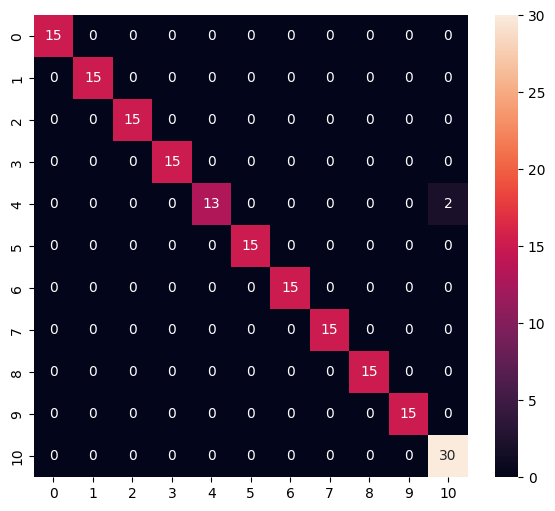

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        15
           4       1.00      0.87      0.93        15
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00        15
          10       0.94      1.00      0.97        30

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(classification_labels_test, y_pred))

Y_pred = model.predict(new_input_a_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(classification_labels_test, y_pred)

# Convert to model for Tensorflow-Lite

In [40]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

C:\Users\Cristina\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Cristina\AppData\Local\Temp\tmplb3ms1ao\assets


INFO:tensorflow:Assets written to: C:\Users\Cristina\AppData\Local\Temp\tmplb3ms1ao\assets


21064

# Inference test

In [42]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [43]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [44]:
# convert to float32
input_a_test = input_a_test.astype(np.float32)
interpreter.set_tensor(input_details[0]['index'], np.array([input_a_test[0]]))

In [45]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 3 ms


In [46]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[7.3170391e-08 6.6808808e-01 1.4656565e-04 3.2894814e-01 4.7518784e-05
 1.8160679e-09 1.2721411e-05 5.0021178e-08 3.5058038e-05 6.3463386e-07
 2.7211499e-03]
1
